# SWE-bench Trajectory Analysis

This notebook analyzes agent trajectories to identify suitable failed tasks for detailed study.

In [1]:
import json
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set up paths
BASE_DIR = Path('evaluation/python/verified/20250329_OpenHands_Claude-3.5-Sonnet(Oct)')
RESULTS_PATH = BASE_DIR / 'results' / 'results.json'
TRAJS_DIR = BASE_DIR / 'trajs'

print(f"Base directory exists: {BASE_DIR.exists()}")
print(f"Results file exists: {RESULTS_PATH.exists()}")
print(f"Trajectories directory exists: {TRAJS_DIR.exists()}")

Base directory exists: True
Results file exists: True
Trajectories directory exists: True


In [2]:
# Load results data
with open(RESULTS_PATH, 'r') as f:
    results_data = json.load(f)

print(f"Total instances: {results_data['total_instances']}")
print(f"Resolved instances: {results_data['resolved_instances']}")
print(f"Unresolved instances: {results_data['unresolved_instances']}")

unresolved_tasks = results_data.get('unresolved_ids', [])
print(f"\nFirst 10 unresolved tasks:")
for task in unresolved_tasks[:10]:
    print(f"  - {task}")

Total instances: 500
Resolved instances: 195
Unresolved instances: 252

First 10 unresolved tasks:
  - django__django-13195
  - django__django-13212
  - django__django-13297
  - django__django-13568
  - django__django-13128
  - django__django-13279
  - django__django-13449
  - django__django-13315
  - django__django-13363
  - django__django-13346


In [3]:
def load_trajectory(task_id):
    """Load trajectory JSON for a given task ID"""
    task_dir = TRAJS_DIR / task_id
    if not task_dir.exists():
        return None
    
    # Find the JSON file (should be only one)
    json_files = list(task_dir.glob('*.json'))
    if not json_files:
        return None
    
    with open(json_files[0], 'r') as f:
        return json.load(f)

def get_trajectory_stats(task_id):
    """Extract basic stats from a trajectory using structured fncall_messages data"""
    traj = load_trajectory(task_id)
    if not traj:
        return None
    
    # Use structured fncall_messages instead of parsing text
    messages = traj.get('fncall_messages', [])
    if not messages:
        # Fallback to raw messages if fncall_messages not available
        messages = traj.get('messages', [])
    
    stats = {
        'task_id': task_id,
        'total_steps': len([m for m in messages if m.get('role') == 'assistant']),
        'action_types': [],
        'files_modified': set(),
        'commands_run': [],
        'error_count': 0,
        'test_runs': 0,
        'function_calls': []
    }
    
    for i, message in enumerate(messages):
        role = message.get('role', '')
        
        # Process assistant messages with structured tool calls
        if role == 'assistant':
            tool_calls = message.get('tool_calls', [])
            for tool_call in tool_calls:
                if tool_call.get('type') == 'function':
                    func_details = tool_call.get('function', {})
                    func_name = func_details.get('name', '')
                    
                    if func_name:
                        stats['action_types'].append(func_name)
                        stats['function_calls'].append(func_name)
                        
                        # Parse function arguments (JSON string)
                        import json as json_lib
                        try:
                            args = json_lib.loads(func_details.get('arguments', '{}'))
                            
                            # Track file modifications
                            if func_name == 'str_replace_editor' and 'path' in args:
                                stats['files_modified'].add(args['path'])
                            
                            # Track bash commands
                            elif func_name == 'execute_bash' and 'command' in args:
                                cmd = args['command']
                                stats['commands_run'].append(cmd)
                                if any(test_keyword in cmd.lower() for test_keyword in ['test', 'pytest', 'unittest']):
                                    stats['test_runs'] += 1
                        
                        except json_lib.JSONDecodeError:
                            # If JSON parsing fails, fall back to the function name only
                            pass
        
        # Process tool execution results
        elif role == 'tool':
            content = message.get('content', '')
            if any(keyword in content.lower() for keyword in ['error', 'exception', 'failed', 'traceback']):
                stats['error_count'] += 1
        
        # Fallback: Process user messages for execution results (if using raw messages)
        elif role == 'user' and 'EXECUTION RESULT' in message.get('content', ''):
            content = message.get('content', '')
            if any(keyword in content.lower() for keyword in ['error', 'exception', 'failed', 'traceback']):
                stats['error_count'] += 1
    
    stats['files_modified'] = list(stats['files_modified'])
    
    return stats

In [4]:
# Analyze all unresolved tasks

trajectory_stats = []
for task_id in unresolved_tasks:
    print(f"Analyzing {task_id}...")
    stats = get_trajectory_stats(task_id)
    if stats:
        trajectory_stats.append(stats)

print(f"\nAnalyzed {len(trajectory_stats)} trajectories")

Analyzing django__django-13195...
Analyzing django__django-13212...
Analyzing django__django-13297...
Analyzing django__django-13568...
Analyzing django__django-13128...
Analyzing django__django-13279...
Analyzing django__django-13449...
Analyzing django__django-13315...
Analyzing django__django-13363...
Analyzing django__django-13346...
Analyzing django__django-13512...
Analyzing django__django-13158...
Analyzing django__django-13807...
Analyzing django__django-13794...
Analyzing django__django-14034...
Analyzing django__django-14155...
Analyzing django__django-13344...
Analyzing django__django-13820...
Analyzing django__django-14315...
Analyzing django__django-13964...
Analyzing django__django-14376...
Analyzing django__django-14238...
Analyzing django__django-14011...
Analyzing django__django-14493...
Analyzing django__django-14534...
Analyzing django__django-14170...
Analyzing django__django-14631...
Analyzing django__django-14559...
Analyzing django__django-14053...
Analyzing djan

In [5]:
# Create DataFrame for easier analysis
df_stats = pd.DataFrame(trajectory_stats)

# Display basic statistics
print("Trajectory Statistics:")
print(df_stats[['task_id', 'total_steps', 'error_count']].describe())

# Show tasks with interesting characteristics
print("\nTasks with most steps:")
print(df_stats.nlargest(5, 'total_steps')[['task_id', 'total_steps', 'error_count']])

print("\nTasks with most errors:")
print(df_stats.nlargest(5, 'error_count')[['task_id', 'total_steps', 'error_count']])

print("\nTasks with most file modifications:")
df_stats['num_files_modified'] = df_stats['files_modified'].apply(len)
print(df_stats.nlargest(5, 'num_files_modified')[['task_id', 'total_steps', 'num_files_modified', 'error_count']])

Trajectory Statistics:
       total_steps  error_count
count   252.000000   252.000000
mean     41.285714    16.428571
std      11.317129     9.740398
min      12.000000     1.000000
25%      32.750000     9.000000
50%      49.000000    15.000000
75%      49.000000    23.000000
max      49.000000    48.000000

Tasks with most steps:
                task_id  total_steps  error_count
2  django__django-13297           49           24
3  django__django-13568           49           26
4  django__django-13128           49           40
6  django__django-13449           49           28
7  django__django-13315           49           14

Tasks with most errors:
                  task_id  total_steps  error_count
179    psf__requests-5414           49           48
178  django__django-16667           49           44
97   django__django-10097           49           42
114  django__django-11532           49           42
226    sympy__sympy-22456           49           41

Tasks with most file modifi

Most common action types:
str_replace_editor    6224
execute_bash          4175
Name: count, dtype: int64


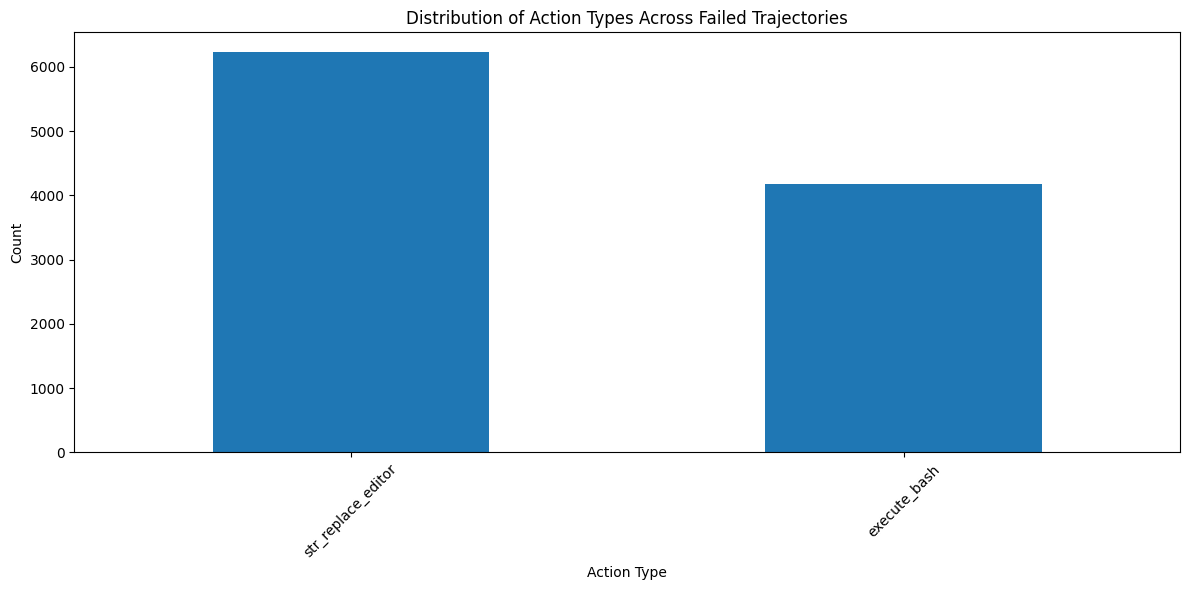

In [6]:
# Analyze action types across trajectories
all_actions = []
for stats in trajectory_stats:
    all_actions.extend(stats['action_types'])

if all_actions:
    action_counts = pd.Series(all_actions).value_counts()
    print("Most common action types:")
    print(action_counts.head(10))

    # Plot action distribution
    plt.figure(figsize=(12, 6))
    action_counts.head(10).plot(kind='bar')
    plt.title('Distribution of Action Types Across Failed Trajectories')
    plt.xlabel('Action Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No actions found in trajectories - check data structure")

In [7]:
# Find tasks with good complexity for analysis using the following scoring algorithm

df_stats['num_files_modified'] = df_stats['files_modified'].apply(len)

# Apply same scoring algorithm as find_candidates.py
def calculate_score(row):
    score = 0
    
    # Prefer moderate complexity (15-80 steps)
    steps = row['total_steps']
    if 15 <= steps <= 80:
        score += 10
    elif steps > 80:
        score += 5
    
    # File modifications indicate the agent tried to fix something (×3 weight)
    score += row['num_files_modified'] * 3
    
    # Errors might indicate interesting failure points (×2 weight)
    score += row['error_count'] * 2
    
    # Test runs show the agent was trying to validate (×5 weight)
    score += row['test_runs'] * 5
    
    return score

df_stats['complexity_score'] = df_stats.apply(calculate_score, axis=1)

# Select candidates
candidates = df_stats.sort_values('complexity_score', ascending=False)

print("Top candidates for detailed analysis (using find_candidates.py scoring):")
print(candidates[['task_id', 'total_steps', 'num_files_modified', 'error_count', 'test_runs', 'complexity_score']].head(10))

Top candidates for detailed analysis (using find_candidates.py scoring):
                     task_id  total_steps  num_files_modified  error_count  \
226       sympy__sympy-22456           49                   2           41   
68   pytest-dev__pytest-6197           49                   7           24   
91    astropy__astropy-14365           49                   2           38   
139     django__django-16256           49                   2           24   
67   pytest-dev__pytest-5787           49                   5           38   
72   pytest-dev__pytest-5840           44                   6           21   
135     django__django-15973           48                  10           17   
64   pylint-dev__pylint-7080           49                  15           26   
105     django__django-11292           49                   3           28   
235  sphinx-doc__sphinx-7462           49                   7           31   

     test_runs  complexity_score  
226         18               188 

In [8]:
# Examine the top candidate in detail using structured data
if not candidates.empty:
    top_candidate = candidates.iloc[0]['task_id']
    print(f"Examining top candidate: {top_candidate}")
    
    # Load full trajectory
    traj = load_trajectory(top_candidate)
    
    if traj:
        # Use structured fncall_messages for better parsing
        messages = traj.get('fncall_messages', traj.get('messages', []))
        assistant_messages = [m for m in messages if m.get('role') == 'assistant']
        
        print(f"\nTrajectory overview:")
        print(f"Total messages: {len(messages)}")
        print(f"Assistant steps: {len(assistant_messages)}")
        
        # Show first few assistant actions using structured data
        print(f"\nFirst 3 assistant actions:")
        count = 0
        for message in messages:
            if message.get('role') == 'assistant' and count < 3:
                # Use structured tool_calls instead of regex parsing
                tool_calls = message.get('tool_calls', [])
                if tool_calls:
                    for tool_call in tool_calls:
                        if tool_call.get('type') == 'function':
                            func_name = tool_call.get('function', {}).get('name', 'unknown')
                            print(f"Step {count+1}: {func_name}")
                            
                            # Show reasoning from content (first 100 chars)
                            reasoning = message.get('content', '').strip()
                            if reasoning:
                                print(f"  Reasoning: {reasoning[:100]}...")
                            
                            # Show function arguments
                            args = tool_call.get('function', {}).get('arguments', '{}')
                            try:
                                import json as json_lib
                                parsed_args = json_lib.loads(args)
                                key_args = {k: v for k, v in parsed_args.items() if k in ['path', 'command', 'new_str']}
                                if key_args:
                                    print(f"  Key args: {key_args}")
                            except json_lib.JSONDecodeError:
                                pass
                            
                            count += 1
                            break
                if count >= 3:
                    break
        
        # Project info (following task ID format: org__repo-issue)
        parts = top_candidate.split('__')
        if len(parts) == 2:
            org_name = parts[0]
            repo_and_issue = parts[1]
            repo_parts = repo_and_issue.split('-')
            repo_name = '-'.join(repo_parts[:-1])
            issue_num = repo_parts[-1]
            github_url = f"https://github.com/{org_name}/{repo_name}/pull/{issue_num}"
            print(f"\nProject: {org_name}/{repo_name}")
            print(f"Issue/PR number: {issue_num}")
            print(f"GitHub URL: {github_url}")
    else:
        print("Could not load trajectory data")
else:
    print("No candidates found in sample")

Examining top candidate: sympy__sympy-22456

Trajectory overview:
Total messages: 100
Assistant steps: 49

First 3 assistant actions:
Step 1: execute_bash
  Reasoning: I'll help you implement the necessary changes. Let's start by exploring the repository structure to ...
  Key args: {'command': 'ls -R /workspace/sympy__sympy__1.10'}
Step 2: execute_bash
  Reasoning: Based on the issue description, we need to modify the `String` class in the `codegen.ast` module to ...
  Key args: {'command': 'find /workspace/sympy__sympy__1.10 -type f -name "ast.py"'}
Step 3: str_replace_editor
  Reasoning: Let me examine the content of the ast.py file to locate the String class and understand its current ...
  Key args: {'command': 'view', 'path': '/workspace/sympy__sympy__1.10/sympy/codegen/ast.py'}

Project: sympy/sympy
Issue/PR number: 22456
GitHub URL: https://github.com/sympy/sympy/pull/22456


In [9]:
# Helper function for deep trajectory analysis using structured data
def analyze_trajectory_libraries(task_id):
    """
    Perform deep analysis of a trajectory using structured fncall_messages data
    """
    traj = load_trajectory(task_id)
    if not traj:
        return None
    
    # Use structured fncall_messages for analysis
    messages = traj.get('fncall_messages', traj.get('messages', []))
    
    analysis = {
        'task_id': task_id,
        'python_libraries': set(),
        'frameworks': set(),
        'key_errors': [],
        'tool_usage': {},
        'file_operations': []
    }
    
    for i, message in enumerate(messages):
        role = message.get('role', '')
        content = message.get('content', '')
        
        # Analyze assistant tool calls using structured data
        if role == 'assistant':
            tool_calls = message.get('tool_calls', [])
            for tool_call in tool_calls:
                if tool_call.get('type') == 'function':
                    func_details = tool_call.get('function', {})
                    func_name = func_details.get('name', '')
                    
                    # Track tool usage
                    if func_name:
                        analysis['tool_usage'][func_name] = analysis['tool_usage'].get(func_name, 0) + 1
                        
                        # Parse structured arguments
                        try:
                            import json as json_lib
                            args = json_lib.loads(func_details.get('arguments', '{}'))
                            
                            # Track file operations
                            if func_name == 'str_replace_editor':
                                analysis['file_operations'].append({
                                    'step': i + 1,
                                    'operation': 'edit',
                                    'file': args.get('path', 'unknown'),
                                    'command': args.get('command', 'unknown')
                                })
                        
                        except json_lib.JSONDecodeError:
                            pass
            
            # Extract library/framework mentions from reasoning text
            # (Still need some text analysis for context understanding)
            if 'django' in content.lower():
                analysis['frameworks'].add('django')
            if 'flask' in content.lower():
                analysis['frameworks'].add('flask')
            if 'numpy' in content.lower():
                analysis['frameworks'].add('numpy')
            if 'pandas' in content.lower():
                analysis['frameworks'].add('pandas')
        
        # Analyze tool execution results using structured tool messages
        elif role == 'tool':
            tool_name = message.get('name', 'unknown')
            if any(keyword in content.lower() for keyword in ['error', 'exception', 'traceback']):
                analysis['key_errors'].append({
                    'step': i + 1,
                    'tool': tool_name,
                    'tool_call_id': message.get('tool_call_id', ''),
                    'error_preview': content[:200] + "..." if len(content) > 200 else content
                })
        
        # Fallback for raw messages
        elif role == 'user' and 'EXECUTION RESULT' in content:
            if any(keyword in content.lower() for keyword in ['error', 'exception', 'traceback']):
                analysis['key_errors'].append({
                    'step': i + 1,
                    'tool': 'unknown',
                    'error_preview': content[:200] + "..." if len(content) > 200 else content
                })
    
    analysis['python_libraries'] = list(analysis['python_libraries'])
    analysis['frameworks'] = list(analysis['frameworks'])
    
    return analysis

def get_tool_usage_summary(trajectory_stats):
    """Analyze tool usage patterns across trajectories"""
    tool_usage = {}
    for stats in trajectory_stats:
        for tool_name in stats['action_types']:
            tool_usage[tool_name] = tool_usage.get(tool_name, 0) + 1
    return tool_usage

print("Enhanced helper functions for structured trajectory analysis added")

Enhanced helper functions for structured trajectory analysis added


In [10]:
# Example: Analyze a randomly selected candidate from top 20
import random

if not candidates.empty:
    # Get top 20 candidates and randomly sample one
    top_20_candidates = candidates.head(20)
    selected_candidate = top_20_candidates.sample(1).iloc[0]
    top_candidate = selected_candidate['task_id']
    candidate_rank = top_20_candidates.index.get_loc(selected_candidate.name) + 1
    
    print(f"Randomly selected candidate from top 20: {top_candidate}")
    print(f"Rank: #{candidate_rank} out of top 20")
    print(f"Complexity score: {selected_candidate['complexity_score']}")
    print(f"Stats: {selected_candidate['total_steps']} steps, {selected_candidate['num_files_modified']} files modified, {selected_candidate['error_count']} errors")
    
    # Project info (following task ID format: org__repo-issue)
    parts = top_candidate.split('__')
    if len(parts) == 2:
        org_name = parts[0]
        repo_and_issue = parts[1]
        repo_parts = repo_and_issue.split('-')
        repo_name = '-'.join(repo_parts[:-1])
        issue_num = repo_parts[-1]
        github_url = f"https://github.com/{org_name}/{repo_name}/pull/{issue_num}"
        print("\n" + "="*80)
        print("TASK METADATA")
        print("="*80)
        print(f"Project: {org_name}/{repo_name}")
        print(f"Issue/PR number: {issue_num}")
        print(f"GitHub URL: {github_url}")

    # Load trajectory and extract task description
    traj = load_trajectory(top_candidate)
    if traj:
        # Use structured fncall_messages when available
        messages = traj.get('fncall_messages', traj.get('messages', []))
        
        # Find the first user message containing task description
        for message in messages:
            if message.get('role') == 'user':
                content = message.get('content', '')
                
                # Look for issue description markers
                if "issue_description" in content:
                    print("\n" + "="*80)
                    print("ISSUE DESCRIPTION")
                    print("="*80)
                    
                    # Extract content between markers
                    start_marker = "<issue_description>"
                    end_marker = "</issue_description>"
                    
                    start_idx = content.find(start_marker)
                    end_idx = content.find(end_marker)
                    
                    if start_idx != -1 and end_idx != -1:
                        task_desc = content[start_idx + len(start_marker):end_idx].strip()
                        print(f"{task_desc[:500]}...")
                    else:
                        print("Issue description markers found but could not extract content")
                    print("="*80)
                    break
        
        # Perform deep analysis using structured data
        deep_analysis = analyze_trajectory_libraries(top_candidate)
        if deep_analysis:
            print("\n" + "="*80)
            print("STRUCTURED DATA ANALYSIS")
            print("="*80)
            print(f"Tool usage: {deep_analysis['tool_usage']}")
            print(f"Frameworks detected: {deep_analysis['frameworks']}")
            print(f"File operations: {len(deep_analysis['file_operations'])}")
            print(f"Errors encountered: {len(deep_analysis['key_errors'])}")
            
            if deep_analysis['key_errors']:
                print(f"\nFirst few errors:")
                for error in deep_analysis['key_errors'][:3]:
                    print(f"  Step {error['step']} ({error.get('tool', 'unknown')}): {error['error_preview'][:100]}...")
    else:
        print("Could not load trajectory for task description extraction")
else:
    print("No candidates found")

print("\nRandom sampling from top 20 candidates implemented")

Randomly selected candidate from top 20: sphinx-doc__sphinx-7462
Rank: #10 out of top 20
Complexity score: 148
Stats: 49 steps, 7 files modified, 31 errors

TASK METADATA
Project: sphinx-doc/sphinx
Issue/PR number: 7462
GitHub URL: https://github.com/sphinx-doc/sphinx/pull/7462

ISSUE DESCRIPTION
`IndexError: pop from empty list` for empty tuple type annotation
**Describe the bug**
Following notation for empty tuple from [this mypy issue](https://github.com/python/mypy/issues/4211) like
```python
from typing import Tuple

def foo() -> Tuple[()]:
	"""Sample text."""
    return ()
```
I get
```bash
  File "\path\to\site-packages\sphinx\domains\python.py", line 112, in unparse
    result.pop()
IndexError: pop from empty list
```

**To Reproduce**
Steps to reproduce the beha...

STRUCTURED DATA ANALYSIS
Tool usage: {'execute_bash': 19, 'str_replace_editor': 30}
Frameworks detected: []
File operations: 30
Errors encountered: 31

First few errors:
  Step 4 (execute_bash): /workspace/sphinx-d